In [2]:
import geopandas as gpd
import pandas as pd
from sklearn.cluster import KMeans

In [3]:
sample = gpd.read_file('../2016_통계청_집계구경계(EPSG5179)/bnd_oa_00_2016.shp')

In [4]:
sample['CENTER_X'] = sample.geometry.apply(lambda p : p.centroid.x)
sample['CENTER_Y'] = sample.geometry.apply(lambda p : p.centroid.y)

In [5]:
def near_park(df):
    '''범위내 축소 
    
    '''
    # 대공원주변 범위
    ymin,ymax = 1949300, 1951100
    xmin,xmax = 962000, 964100
    
    target = df[(df.CENTER_X >= xmin)&(df.CENTER_X <= xmax)]
    target = target[(target.CENTER_Y >= ymin)&(target.CENTER_Y <= ymax)]
    
    #건대상권 제외
    gun_x, gun_y = 962250, 1949600
    target = target[~((target.CENTER_X <= gun_x)&((target.CENTER_Y <= gun_y)))]
    
    #이상한곳1
    gun_x, gun_y = 962100, 1950500
    target = target[~((target.CENTER_X <= gun_x)&((target.CENTER_Y >= gun_y)))]
    #이상한곳2
    gun_x, gun_y = 962200, 1950800
    target = target[~((target.CENTER_X <= gun_x)&((target.CENTER_Y >= gun_y)))]
    return target

In [6]:
sample_n = near_park(sample)

In [7]:
center_points = sample_n[['CENTER_X','CENTER_Y']].drop_duplicates()

kmeans = KMeans(n_clusters = 10,random_state=42).fit(center_points)
center_points['labels'] = kmeans.labels_

center_points.loc[((center_points.CENTER_X >= 962900)&(center_points.CENTER_X <= 963100)&
               (center_points.CENTER_Y >= 1950000)&(center_points.CENTER_Y <= 1950250)),'labels'] = 10

In [8]:
sample_n = sample_n.merge(center_points, on = ['CENTER_X','CENTER_Y'],how = 'left')

In [9]:
cluster_name = {0: "후문뒤편",
                1: "군자역",
                2: "구의문",
                3: "세종대",
                4: "정문",
                5: "군자역뒤편",
                6: "후문(아차산역)",
                7: "남문",
                8: "구의문뒤편",
                9: "서문&북문",
                10: "어린이대공원"}

In [10]:
cluster_name_df = pd.DataFrame({'labels': list(cluster_name.keys()), 'CLUSTER_NAME': list(cluster_name.values())})

In [11]:
sample_n = sample_n.merge(cluster_name_df,how ='left')
center_points = center_points.merge(cluster_name_df,how ='left')

In [12]:
legend = list(cluster_name.values())
handles = list(cluster_name.keys())

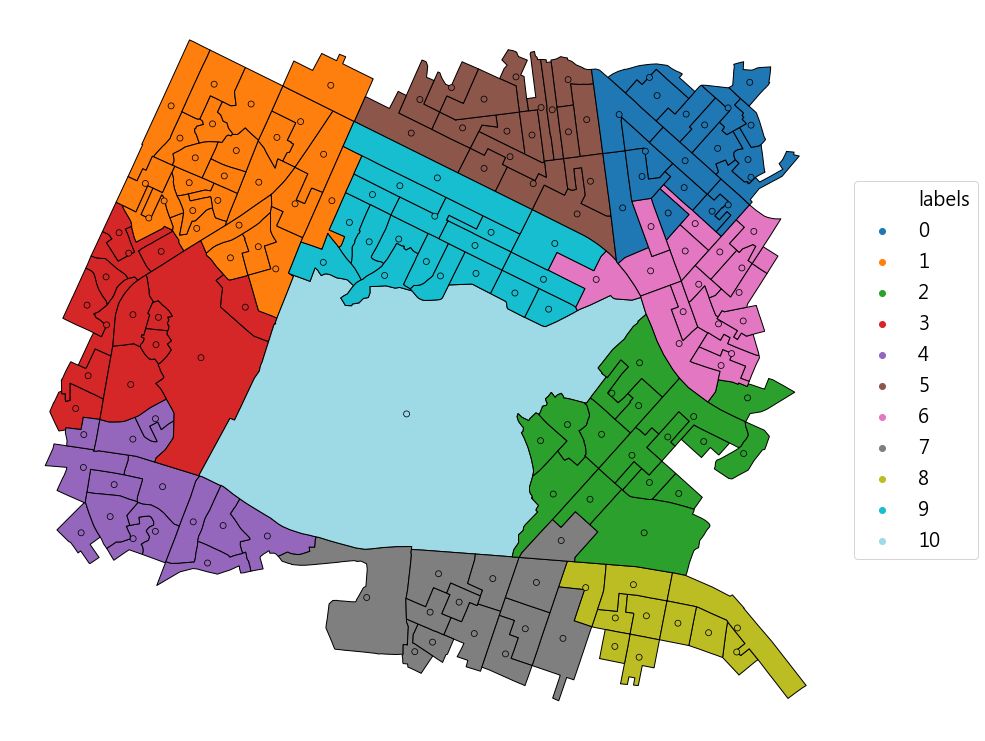

In [18]:
#컬러확정
label_num = center_points['labels'].nunique()
color_list = [plt.cm.get_cmap('tab20')(c) for c in np.linspace(0, 1,label_num)]

sample_n.plot(column = 'labels', edgecolor = 'black',figsize = (15,15),cmap = 'tab20')
sns.scatterplot(x = 'CENTER_X', y = 'CENTER_Y',hue= 'labels',data = center_points,
                edgecolor = 'black',palette = color_list)
plt.legend(loc = 'center left', bbox_to_anchor = (1,0.5),fontsize = 20)
plt.axis('off')
plt.savefig('클러스터_no_point.png', bbox_inches='tight',transparent=True)
plt.show()

### 클러스터 병합

In [21]:
from shapely.ops import cascaded_union

In [22]:
union_polygon = {}
for label in sample_n.labels.unique():
    union_polygon[label] = cascaded_union(sample_n[sample_n.labels == label].geometry)

geo_df = pd.DataFrame({'labels': list(union_polygon.keys()), 'geometry': list(union_polygon.values())})

In [24]:
geo_df = gpd.GeoDataFrame(pd.merge(cluster_name_df,geo_df))

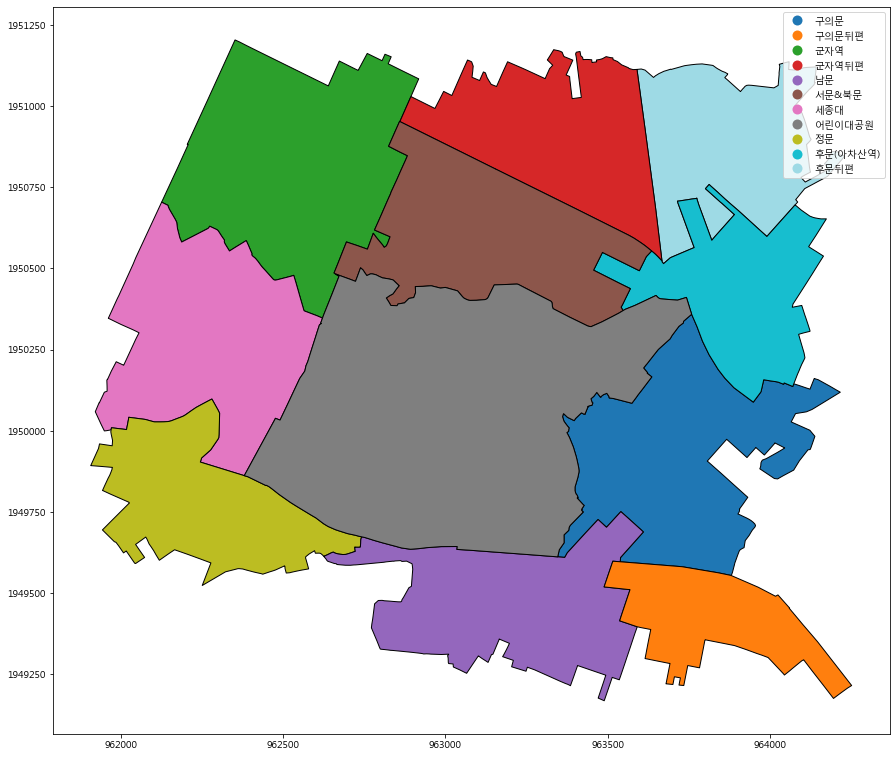

In [28]:
geo_df.plot(column = 'CLUSTER_NAME',edgecolor = 'black',cmap = 'tab20', figsize = (15,15),legend = True)

In [ ]:
#shap 저장
geo_df.to_file('./data/신한카드데이터/라벨별_명칭_geo값.shp',encoding = 'cp949')

In [ ]:
#클러스터 저장
center_points_save.to_csv('./data/신한카드데이터/블럭별 클러스터라벨.csv',index= False)